In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pandas as pd
import seaborn as sns

In [85]:
sns.set()

In [2]:
topology = md.load_prmtop('prmtop.parm7')
topology

<mdtraj.Topology with 1 chains, 42 residues, 630 atoms, 636 bonds at 0x7f2663db2550>

In [3]:
trajectory = md.load_netcdf('mdcrd.310.nc', top=topology)
trajectory

<mdtraj.Trajectory with 25000 frames, 630 atoms, 42 residues, without unitcells at 0x7f2663bec290>

In [4]:
dssp = md.compute_dssp(trajectory, simplified=False)
dssp

array([[' ', ' ', 'T', ..., 'S', ' ', ' '],
       [' ', ' ', 'G', ..., 'T', 'T', ' '],
       [' ', ' ', 'G', ..., 'G', 'G', ' '],
       ...,
       [' ', ' ', 'H', ..., 'T', 'T', ' '],
       [' ', 'H', 'H', ..., 'T', 'T', ' '],
       [' ', 'H', 'H', ..., 'T', 'T', ' ']], dtype='<U2')

In [5]:
print(dssp.shape)

(25000, 42)


In [6]:
# structures = ['H', 'B', 'E', 'G', 'I', 'T', 'S', ' ']
# for structure in structures:
#     count = np.count_nonzero(dssp.flatten() == structure)
#     print(structure, count/dssp.flatten().size)

H 0.3496542857142857
B 0.009241904761904762
E 0.01728
G 0.11388
I 0.012429523809523809
T 0.20192
S 0.08765714285714286
  0.20793714285714285


## Jackknife法による誤差評価

In [10]:
trajectory.n_frames

25000

In [39]:
n_bins = 5
interval = int(trajectory.n_frames / n_bins)
distribution_bin = []

for i in range(n_bins):
    dssp = md.compute_dssp(trajectory[i*interval:(i+1)*interval], simplified=False)
    distribution = []
    for structure in structures:
        count = np.count_nonzero(dssp.flatten() == structure)
        distribution.append(count/dssp.flatten().size)
    distribution_bin.append(distribution)
    
dssp_df = pd.DataFrame(distribution_bin, columns=structures)
dssp_df

,H,B,E,G,I,T,S,
0,0.279314,0.009967,0.018443,0.127305,0.015910,0.230505,0.101167,0.217390
1,0.275324,0.005757,0.052843,0.138681,0.011681,0.213519,0.088348,0.213848
2,0.342371,0.025214,0.011143,0.106429,0.020133,0.187486,0.082552,0.224671
3,0.494500,0.002157,0.002362,0.084952,0.007338,0.178181,0.077519,0.152990
4,0.356762,0.003114,0.001610,0.112033,0.007086,0.199910,0.088700,0.230786


In [45]:
# 他のシミュレーションとの比較のために変換
dssp_df['Helix'] = dssp_df['H'] + dssp_df['G'] + dssp_df['I']
dssp_df['Beta'] = dssp_df['B'] + dssp_df['E']
dssp_df['Bend'] = dssp_df['S']
dssp_df['Turn'] = dssp_df['T']
dssp_df['Coil'] = dssp_df[' ']
dssp_df

,H,B,E,G,I,T,S,,Helix,Beta,Bend,Turn,Coil
0,0.279314,0.009967,0.018443,0.127305,0.015910,0.230505,0.101167,0.217390,0.422529,0.028410,0.101167,0.230505,0.217390
1,0.275324,0.005757,0.052843,0.138681,0.011681,0.213519,0.088348,0.213848,0.425686,0.058600,0.088348,0.213519,0.213848
2,0.342371,0.025214,0.011143,0.106429,0.020133,0.187486,0.082552,0.224671,0.468933,0.036357,0.082552,0.187486,0.224671
3,0.494500,0.002157,0.002362,0.084952,0.007338,0.178181,0.077519,0.152990,0.586790,0.004519,0.077519,0.178181,0.152990
4,0.356762,0.003114,0.001610,0.112033,0.007086,0.199910,0.088700,0.230786,0.475881,0.004724,0.088700,0.199910,0.230786


In [80]:
estimates_acd = []
errors_acd = []
for structure in dssp_df.columns[8:]:
    means = []
    for i in range(n_bins):
        means.append(dssp_df.drop(i)[structure].mean())
    means = np.array(means)
    print(structure)
    print(means)
    print('Estimate:', means.mean())
    print('Error:', means.std())
    print()
    
    estimates_acd.append(means.mean())
    errors_acd.append(means.std())

Helix
[0.48932262 0.48853333 0.47772143 0.44825714 0.47598452]
Estimate: 0.47596380952380957
Error: 0.014880858525418303

Beta
[0.02605    0.01850238 0.0240631  0.03202262 0.03197143]
Estimate: 0.026521904761904764
Error: 0.005109527726000365

Bend
[0.08427976 0.08748452 0.08893333 0.09019167 0.08739643]
Estimate: 0.08765714285714285
Error: 0.0019777231577975977

Turn
[0.19477381 0.19902024 0.20552857 0.20785476 0.20242262]
Estimate: 0.20192000000000002
Error: 0.004646987625433241

Coil
[0.20557381 0.20645952 0.20375357 0.22167381 0.202225  ]
Estimate: 0.20793714285714282
Error: 0.0070227567168998535



In [82]:
import pickle
with open('estimates_acd.pickle', mode='wb') as f:
    pickle.dump(estimates_acd, f)

In [83]:
with open('errors_acd.pickle', mode='wb') as f:
    pickle.dump(errors_acd, f)

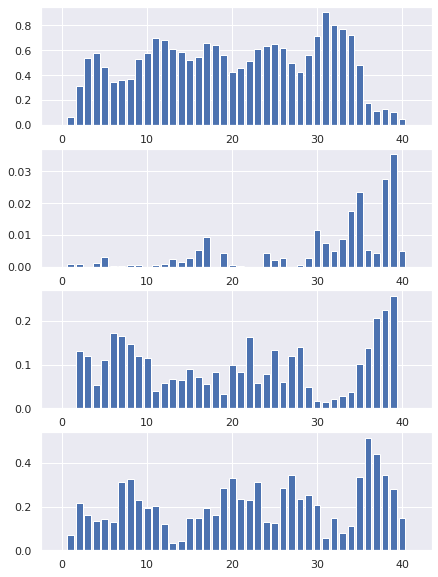

In [86]:
n_residues = 42
dists = []

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7,10))

dists.append(((dssp == 'H') | (dssp == 'G') | (dssp == 'I')).mean(axis=0))
ax1.bar(range(n_residues), dists[0])

dists.append(((dssp == 'E') | (dssp == 'B')).mean(axis=0))
ax2.bar(range(n_residues), dists[1])

dists.append((dssp == 'S').mean(axis=0))
ax3.bar(range(n_residues), dists[2])

dists.append((dssp == 'T').mean(axis=0))
ax4.bar(range(n_residues), dists[3])

# dists = (dssp == ' ').mean(axis=0)
# ax5.bar(range(n_residues), dists)

plt.show()

In [89]:
with open('ss_dists_acd.pickle', mode='wb') as f:
    pickle.dump(dists, f)